<a href="https://colab.research.google.com/github/PaulinaJohn/Building_a_Sentiment_Analysis_Engine_using_Tweets_about_Apple/blob/main/Apple_tweets_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Aim:__

Building a model to analyze sentiments behind tweets about Apple- the company- and its products.

### __Setting up__

In [ ]:
# Importing dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(10,6)})
import re
import nltk
nltk.download("stopwords")  # You may need to do this if don't have the nltk corpora (singlular: corpus) already downloaded in your environment
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # now needed to load wordnet on linux, i guess- as I am using google collab- and collab runs on linux
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import  WordNetLemmatizer
from wordcloud import WordCloud
#!pip install Afinn
from afinn import Afinn
#!pip install vaderSentiment
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
# Loading in the data

apple_tweets = pd.read_csv("/content/apple-twitter-sentiment-texts.csv").rename(columns= {"text":"tweet"})[["tweet"]]  # leisure project dataset shared b a senior colleague

# rename the column containing the tweets from `text` to `tweet`, and I only want the `tweet` column

### __Getting to know the data__

In [ ]:
apple_tweets.head()

,tweet
0,Wow. Yall needa step it up @Apple RT @heynyla:...
1,What Happened To Apple Inc? http://t.co/FJEX...
2,Thank u @apple I can now compile all of the pi...
3,The oddly uplifting story of the Apple co-foun...
4,@apple can i exchange my iphone for a differen...


In [ ]:
apple_tweets.shape

(1630, 1)

### __Preprocessing__

Begining with addressing duplicate records and missing values, then explicit text cleaning and preprocessing.

In [ ]:
# Checking for duplicate records

print(f"there are {apple_tweets.duplicated().sum()} duplicate records in the data")

there are 6 duplicate records in the data


In [ ]:
# Dropping duplicate records

apple_tweets.drop_duplicates(inplace = True)

# Confirming the change

apple_tweets.shape

(1624, 1)

In [ ]:
# Noticed the index have been tampered with due to dropping duplicate records. Resetting index

apple_tweets.reset_index(drop = True, inplace = True)

In [ ]:
# Checking for missing values
apple_tweets.isna().sum()

tweet    0
dtype: int64

Next: 
* __Remove punctuation__
* __Standardize__ - in this case, conversion to lowercase
* __Tokenize__
* __Remove stopwords__
* __Stem__

In [ ]:
# Creating objects/instances from the text preprocessing classes

stopwords_eng = stopwords.words("english")
lemt = WordNetLemmatizer()    # using a lemmatizer to stem because, noticed its results made more sense than using a stemmer.

In [ ]:
# defining a function to carry out the above-listed steps

def cleantext(text):
    text = re.sub("[^A-Za-z1-9 ]", "", text)            #Regex- If character does not match any of these, replace with an empty string. Not keeping emojis because possibly, not all tweets contain emojis. Might influence the emotion in some tweets over others
    text = text.lower()                                 #standardize- convert every letter to lowercase
    tokens = word_tokenize(text)                        #split sentence into individual words- the usual split funtion works as a low-level solution
    cleaned_txt = []                                    # collect each word split out of each tweet into a list.
    for token in tokens:                                # for each of the words.....
        if token not in stopwords_eng:                  #run each word through the english stopwords collection and remove every word that is a stopword
            cleaned_txt.append(lemt.lemmatize(token))   #lemmatization compares each word to an in-built dictionary. It is not rule-based like a stemmer)
    return " ".join(cleaned_txt)                        #combine the tokenized words into a string of words again.

In [ ]:
# applying the function to the `tweet` column

apple_tweets["tweet"] = apple_tweets.tweet.apply(cleantext)

In [ ]:
apple_tweets

,tweet
0,wow yall needa step apple rt heynyla music sna...
1,happened apple inc httptcofjexi3opu aapl apple...
2,thank u apple compile pic communicate one plac...
3,oddly uplifting story apple cofounder sold sta...
4,apple exchange iphone different color lmao cha...
...,...
1619,pick slack fuck boy apple
1620,finally got iphone 6 mail come box busted scre...
1621,umogames apple ended getting new computer anyh...
1622,19yearold wizkid turned apple nabbed backing h...


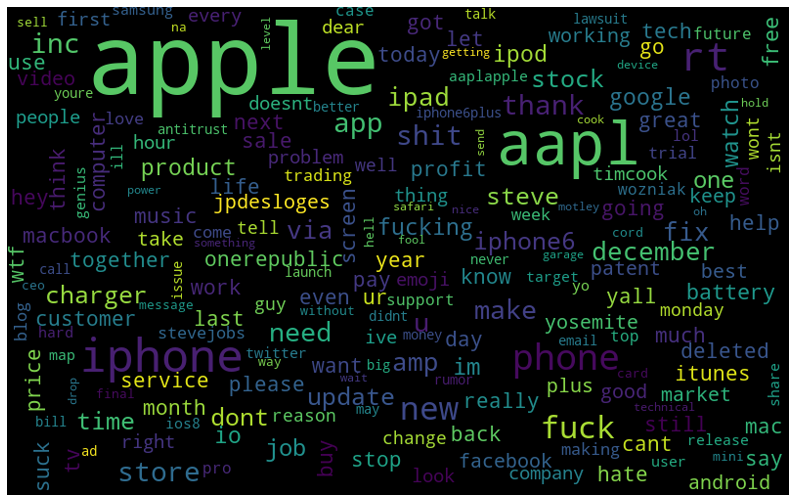

In [ ]:
# A bit of visualization to see which words are most frequent in the tweets, ofcourse, aside 'apple'- using wordcloud

all_tweet_words = ' '.join([tweet for tweet in apple_tweets.tweet])  # This combines all the tweets together as one string
cloud = WordCloud(
    background_color = "black",   # no need to specify the stopwords arguement as I already removed stopwords
    height = 500,
    width = 800,
    random_state = 42,
    max_font_size = 100,
    collocations=False
)
plt.figure(figsize=(14, 10))
cloud.generate(all_tweet_words)
plt.imshow(cloud, interpolation = 'spline16')
plt.axis('off')
plt.show()

### __Building the Model__

Since the dataset is unlabeled, this is an unsupervised learning sentiment analysis problem. I will be using the lexicon-based algorithms.

A lexicon is a special dictionary of words, semantics, grammar- depending on what register of words we are looking at, because, in the case of a sentiment analysis, for eample, we will need a lexicon of words that convey emotions or subjective opinions, with each word having a score, refered to as a polarity score, attached to it, to quantify the sentiment associated with it. Lexicons factor in context and surrounding words, semantics, etc, of the text under consideration.

There is a long list of lexicons out there suitable for analyzing sentiments. For this work, I'll be building two different models using the AFINN and VADER lexicons respectively.

__AFINN__

Safe to say that this lexicon was named after its developer, Finn Årup Nielsen.

In [ ]:
# To begin, making a copy of 'apple_tweets' for the AFINN model. 

apple_tweets_afn = apple_tweets.copy()

apple_tweets_afn.head()

,tweet
0,wow yall needa step apple rt heynyla music sna...
1,happened apple inc httptcofjexi3opu aapl apple...
2,thank u apple compile pic communicate one plac...
3,oddly uplifting story apple cofounder sold sta...
4,apple exchange iphone different color lmao cha...


In [ ]:
# creating an afinn sentiment analyzer instance from the afinn class.

afi = Afinn()

In [ ]:
# function for getting the polarity score (sentiment_score)

def get_score_afn(text):
  score = afi.score(text)
  return score

#function for getting the sentiment

def get_sentiment_afn(text):
  if afi.score(text) > 0:
    return "positive"
  elif afi.score(text) < 0:
    return "negative"
  else:
    return "neutral"

In [ ]:
# applying the functions to the tweets column, and creating new columns in the process

apple_tweets_afn["polarity_score"] = apple_tweets_afn.tweet.apply(get_score_afn)
apple_tweets_afn["sentiment"] = apple_tweets_afn.tweet.apply(get_sentiment_afn)

In [ ]:
# Previewing to see the newly added columns

apple_tweets_afn.tail()

,tweet,polarity_score,sentiment
1619,pick slack fuck boy apple,-4.0,negative
1620,finally got iphone 6 mail come box busted scre...,2.0,positive
1621,umogames apple ended getting new computer anyh...,0.0,neutral
1622,19yearold wizkid turned apple nabbed backing h...,2.0,positive
1623,iphone 6 may longer upgrade cycle expect unit ...,0.0,neutral


Visualizing the sentiments- Which of the sentiments occur most frequently?

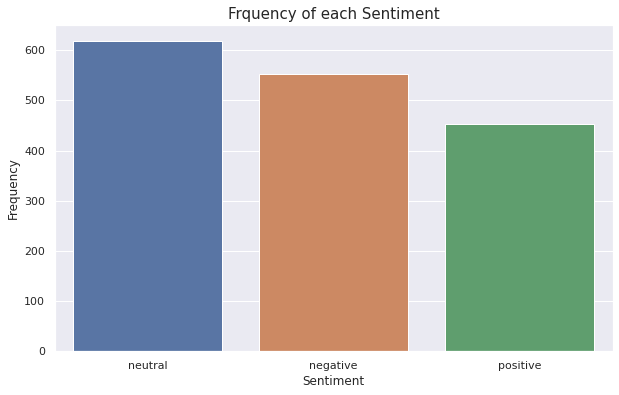

In [ ]:
# Charting sentiments and number times they appear.

plt.figure(figsize=(10, 6))
sns.barplot(data= apple_tweets_afn.groupby("sentiment")[["sentiment"]].count().rename({"sentiment": "frequency"}, axis = 1).reset_index().sort_values("frequency", ascending = False), 
            x= "sentiment", 
            y= "frequency")
plt.title('Frquency of each Sentiment', fontsize = 15)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.show()

From the AFINN model, most of the tweets are neutal towards apple and its products. Also, while the difference may not be staggering, there are more negative than positive tweets about apple.

In [ ]:
# Creating an inference function for new data. # ensures that the steps applied in preprocessing and predicting the sentiment for train data is also used test data.

def infer_afn(text):
    text = cleantext(text)
    score, sentiment = get_score_afn(text), get_sentiment_afn(text)
    return score, sentiment

In [ ]:
# testing the inference function on a new tweet

test_tweet = "@vedanshchn @JimmyOnInOne @UniverseIce I think samsung *thinks* they are copying apple, but they really aren't. Apple knows people don't just want a muted phone and come up with cool colours that still look premium, while samsung thinks that these colours will increase the premium look when in reality it doesn't." # source- a tweet dataset I scraped

infer_afn(test_tweet)

(3.0, 'positive')

__VADER__

Valence Aware Dictionary and sentiment Reasoner

In [ ]:
# creating a vader sentiment analyzer instance from the SentimentIntensityAnalyzer class.

vad = SentimentIntensityAnalyzer()

In [ ]:
# making a copy of apple_tweets for the vader model

apple_tweets_vad = apple_tweets.copy()

apple_tweets_vad.head()

,tweet
0,wow yall needa step apple rt heynyla music sna...
1,happened apple inc httptcofjexi3opu aapl apple...
2,thank u apple compile pic communicate one plac...
3,oddly uplifting story apple cofounder sold sta...
4,apple exchange iphone different color lmao cha...


In [ ]:
# # Getting the polarity score, specifally, compound score

def get_score_vad(text):
    score = round(vad.polarity_scores(text)["compound"], 2)
    return score
    # vader gives a negative, positive and neutral scorea and then, the compound score (all in a dictionary)
    # The compound score is an aggregation of the score of each of the sentiments drawn from each word in the text. The compund score is normalized to between -1 (extremely negative) and 1-extremely positive)- This is what is used to exptrapolate the final sentiment most often.

# Getting the sentiment

def get_sentiment_vad(text):
  if 0 < round(vad.polarity_scores(text)["compound"], 2) <= 1:
    return "positive"
  elif 0 > round(vad.polarity_scores(text)["compound"], 2) >= -1:
    return "negative"
  else:
    return "neutral"

In [ ]:
# applying the function to add corresponding columns to the dataframe

apple_tweets_vad["compound_score"] = apple_tweets_vad.tweet.apply(get_score_vad)
apple_tweets_vad["sentiment"] = apple_tweets_vad.tweet.apply(get_sentiment_vad)

In [ ]:
# Previewing to see newly-added columns

apple_tweets_vad.head()

,tweet,compound_score,sentiment
0,wow yall needa step apple rt heynyla music sna...,0.56,positive
1,happened apple inc httptcofjexi3opu aapl apple...,0.00,neutral
2,thank u apple compile pic communicate one plac...,0.36,positive
3,oddly uplifting story apple cofounder sold sta...,0.00,neutral
4,apple exchange iphone different color lmao cha...,0.60,positive


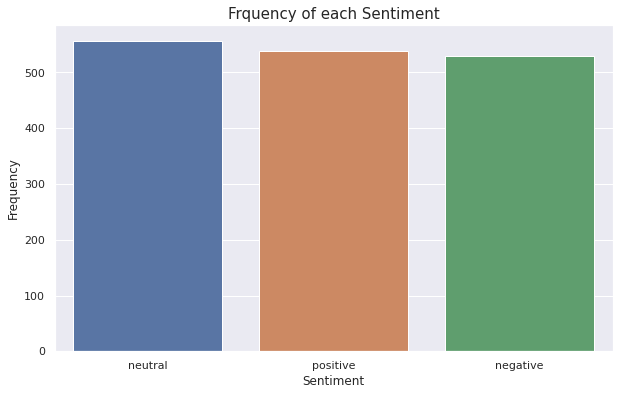

In [ ]:
# Charting sentiments and number times they appear.

plt.figure(figsize=(10, 6))
sns.barplot(data= apple_tweets_vad.groupby("sentiment")[["sentiment"]].count().rename({"sentiment": "frequency"}, axis = 1).reset_index().sort_values("frequency", ascending = False), 
            x= "sentiment", 
            y= "frequency")
plt.title('Frquency of each Sentiment', fontsize = 15)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.show()

From the VADER model, the difference in frequency of occurence of the three sentiments is negligible. Ultimately, class inbalance is also lower here.

In [ ]:
# Creating the inference function for vader

def infer_vad(text):
    text = cleantext(text)
    compound_score, sentiment = get_score_vad(text), get_sentiment_vad(text)
    return compound_score, sentiment

In [ ]:
# calling the function on the same new data used to test the AFINN model.

infer_vad(test_tweet)

(0.52, 'positive')

One shortcoming with lexicon-based models is the variance in sentiment from one lexicon algorithm to another, as can already be seen from the visuals. Sometimes, the difference can be minor though.

Thank you.